In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA
from collections import OrderedDict

from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene

from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from scipy import stats


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=15


alpha = 0.33

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [ ]:
def plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs):

    p = {
      "xlabel": "Gene counts",
      "ylabel": f"Frequency ({gene})",
    }

    for idx, title in enumerate(labels):
    matrix = data[title]
    if idx > 0:
        p.update({"ylabel": ""})
    ax = axs[idx]

    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges 
    ax.hist(t, label="target", alpha=0.5, bins=bins, edgecolor="k", facecolor="#D43F3A")
    ax.hist(c, label="complement", alpha=0.5, bins=bins, edgecolor="k", facecolor="grey")

    p.update({"title": title})
    ax.set(**p)
    return axs

In [39]:
labels = ['raw', 'pf', 'log', 'pf_log', 'pf_log_pf', 'cpm_log', 'cp10k_log', 'cp10k_log_scale', 'sctransform', "sqrt"]

In [36]:
def read_data(base_data_fn):
    data = {}

    for title in labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"_{title}.mtx")
        data[title] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"_{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"_{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values
    return data

In [16]:
ds = "angelidis_2019"
out_prefix =  os.path.join("synchromesh/data/", ds)

In [18]:
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform
loading cp10k_log_scale


In [21]:
bcs = pd.read_csv(os.path.join(out_prefix, "barcodes.csv"), index_col=0)

In [23]:
assignments = bcs.celltype.values

In [28]:
genes = []
read_str_list(os.path.join(out_prefix, "_genes.txt"), genes)
genes = np.array(genes)

In [29]:
genes

array(['Hbb-bs', 'Hba-a1', 'Hba-a2', ..., 'Asb16', 'Plekhg6', 'Zp3'],
      dtype='<U14')

In [37]:

def plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs):

    p = {
      "xlabel": "Gene counts",
      "ylabel": f"Frequency ({gene})",
    }

    for idx, title in enumerate(labels):
        matrix = data[title]
        if idx > 0:
            p.update({"ylabel": ""})
        ax = axs[idx]

        v_gene = matrix[:, gene_mask].flatten()
        t = v_gene[ct_mask]
        c = v_gene[~ct_mask][downsample_idx]
        bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges 
        ax.hist(t, label="target", alpha=0.5, bins=bins, edgecolor="k", facecolor="#D43F3A")
        ax.hist(c, label="complement", alpha=0.5, bins=bins, edgecolor="k", facecolor="grey")

        p.update({"title": title})
        ax.set(**p)
    return axs

### Sftpc in Type 2 Pneumocytes



In [30]:
celltype = "Type_2_pneumocytes"
gene = "Sftpc"

gene_mask = genes == gene
ct_mask = assignments == celltype
size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

ks = {}
for title, matrix in data.items():
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    ks[title] = stats.ks_2samp(t, c)

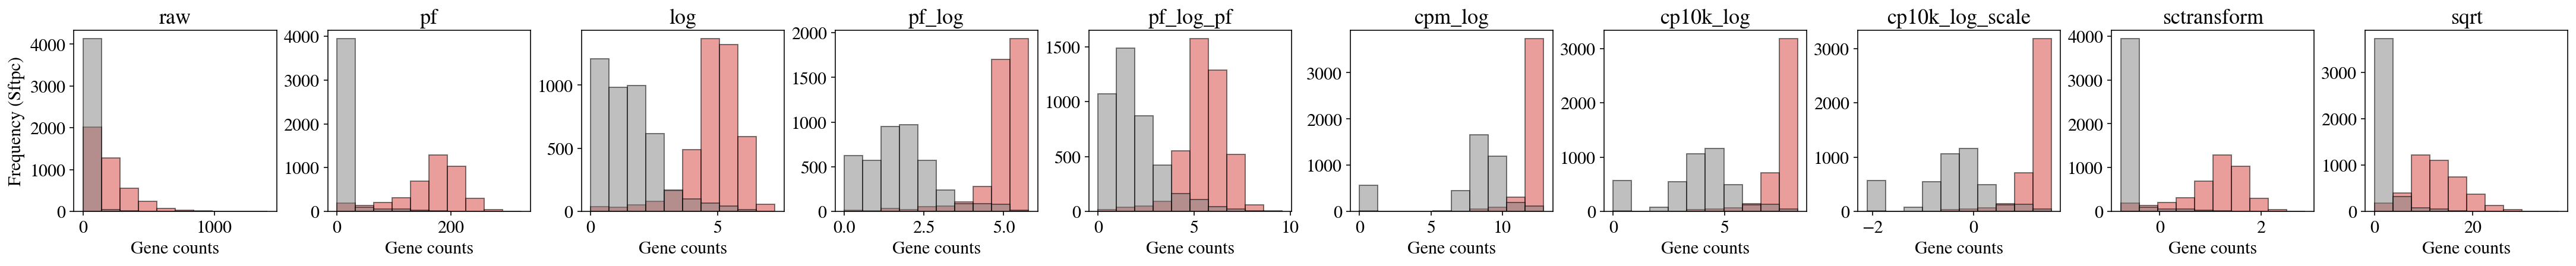

In [40]:
n = len(data.items())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs)

fig.show()

### Scgb1a1 in Club and Goblet cells

In [42]:
celltype1 = "Goblet_cells"
celltype2 = "Club_cells"

ct_mask1 = assignments == celltype1
ct_mask2 = assignments == celltype2

ct_mask = np.logical_or(ct_mask1, ct_mask2)

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

gene = "Scgb1a1"

gene_mask = genes == gene

ks = {}
for title, matrix in data.items():
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    ks[title] = stats.ks_2samp(t, c)

In [43]:
ks

{'raw': KstestResult(statistic=0.8682464454976303, pvalue=0.0),
 'pf': KstestResult(statistic=0.8957345971563981, pvalue=0.0),
 'log': KstestResult(statistic=0.8682464454976303, pvalue=0.0),
 'pf_log': KstestResult(statistic=0.8957345971563981, pvalue=0.0),
 'pf_log_pf': KstestResult(statistic=0.8502369668246446, pvalue=0.0),
 'cpm_log': KstestResult(statistic=0.8957345971563981, pvalue=0.0),
 'cp10k_log': KstestResult(statistic=0.8957345971563981, pvalue=0.0),
 'sqrt': KstestResult(statistic=0.8682464454976303, pvalue=0.0),
 'sctransform': KstestResult(statistic=0.8957345971563981, pvalue=0.0),
 'cp10k_log_scale': KstestResult(statistic=0.8957345971563981, pvalue=0.0)}

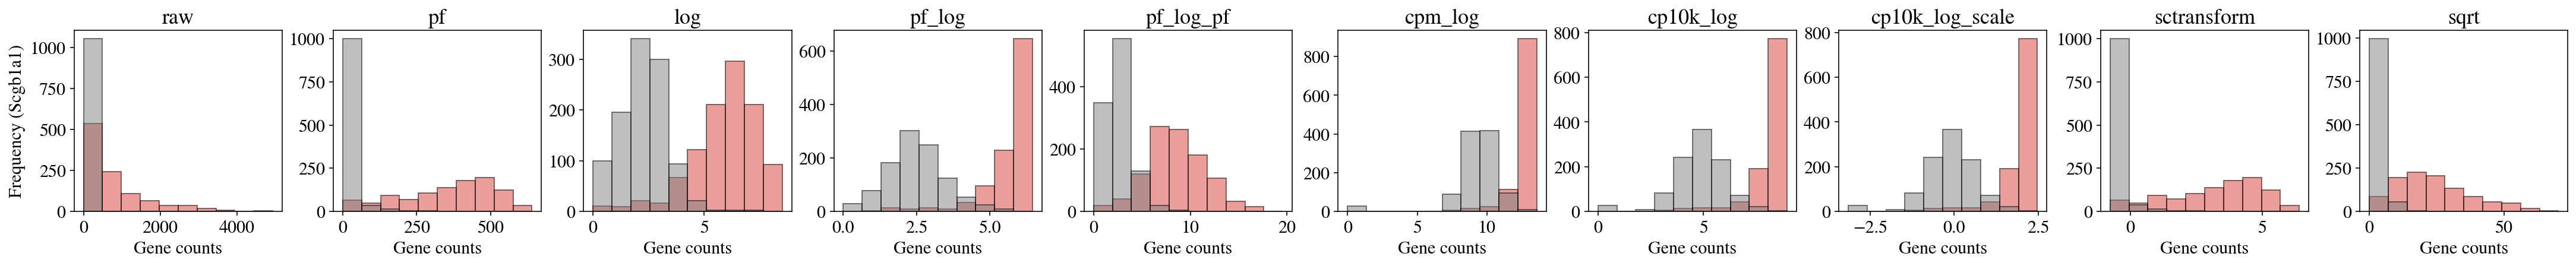

In [44]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs)

fig.show()

### Ear2 in Alveolar Macrophages

In [45]:
celltype = "Alveolar_macrophage"
gene = "Ear2"

ct_mask = assignments == celltype
gene_mask = genes == gene

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

ks = {}
for title, matrix in data.items():
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    ks[title] = stats.ks_2samp(t, c)

In [46]:
ks

{'raw': KstestResult(statistic=0.5845070422535211, pvalue=5.425422268175765e-270),
 'pf': KstestResult(statistic=0.5874413145539906, pvalue=6.5951209249390626e-273),
 'log': KstestResult(statistic=0.5845070422535211, pvalue=5.425422268175765e-270),
 'pf_log': KstestResult(statistic=0.5874413145539906, pvalue=6.5951209249390626e-273),
 'pf_log_pf': KstestResult(statistic=0.585093896713615, pvalue=1.4221395652974608e-270),
 'cpm_log': KstestResult(statistic=0.5874413145539906, pvalue=6.5951209249390626e-273),
 'cp10k_log': KstestResult(statistic=0.5874413145539906, pvalue=6.5951209249390626e-273),
 'sqrt': KstestResult(statistic=0.5845070422535211, pvalue=5.425422268175765e-270),
 'sctransform': KstestResult(statistic=0.5874413145539906, pvalue=6.5951209249390626e-273),
 'cp10k_log_scale': KstestResult(statistic=0.5874413145539906, pvalue=6.5951209249390626e-273)}

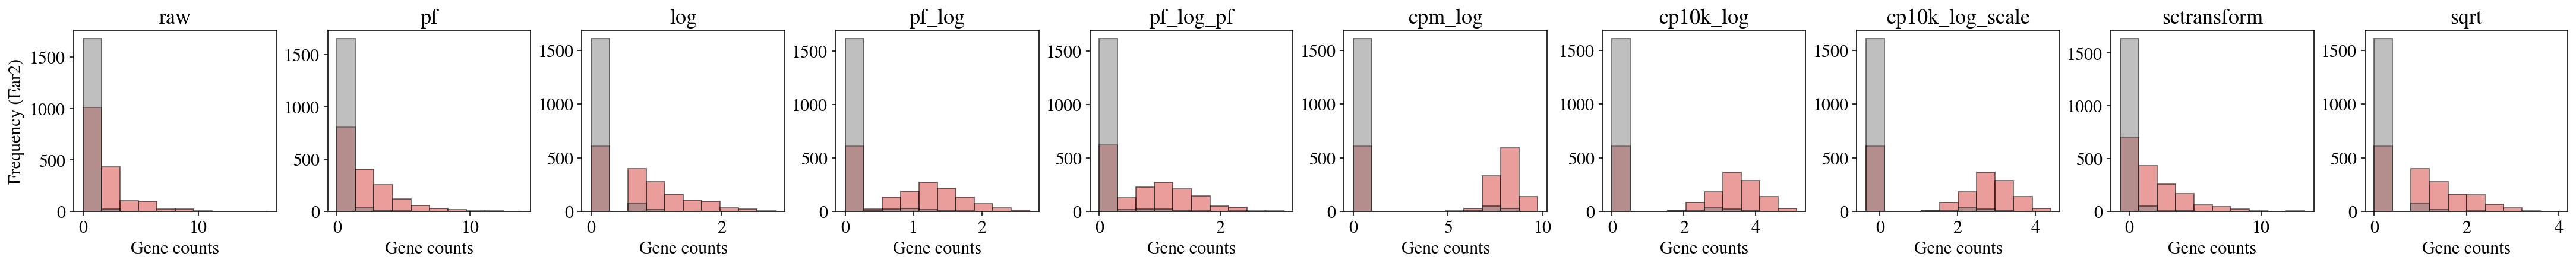

In [47]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs)

fig.show()

# Combined marker genes

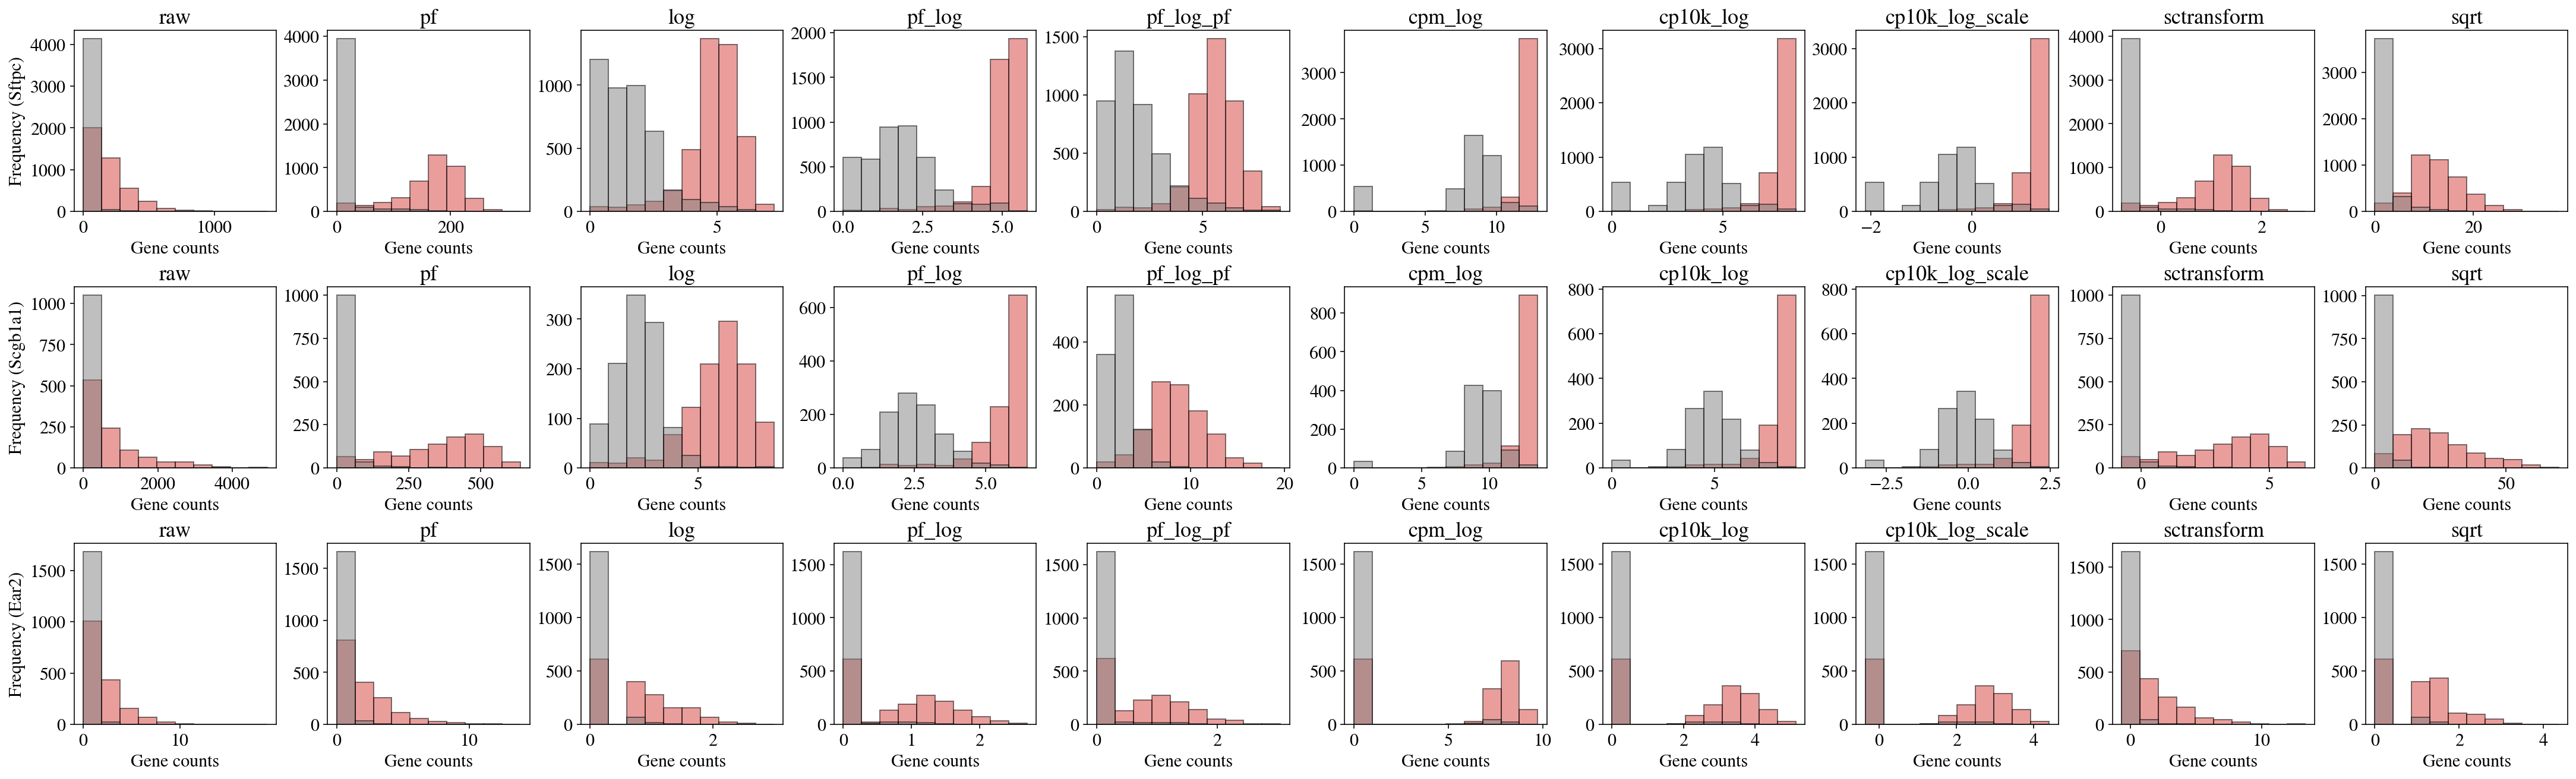

In [48]:
n = len(data.keys())
mg = ["Sftpc", "Scgb1a1", "Ear2"]
m = len(mg)

fig, axs = plt.subplots(figsize=(3*n,3*m), ncols=n,nrows=m, constrained_layout=True)

## First
celltype = "Type_2_pneumocytes"
gene = "Sftpc"

gene_mask = genes == gene
ct_mask = assignments == celltype
size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs[0])

## Second

celltype1 = "Goblet_cells"
celltype2 = "Club_cells"

ct_mask1 = assignments == celltype1
ct_mask2 = assignments == celltype2

ct_mask = np.logical_or(ct_mask1, ct_mask2)

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

gene = "Scgb1a1"

gene_mask = genes == gene

plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs[1])

## third
celltype = "Alveolar_macrophage"
gene = "Ear2"

ct_mask = assignments == celltype
gene_mask = genes == gene

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

plot_celltype_marker_gene(data, gene, ct_mask, gene_mask, downsample_idx, axs[2])

# fig.savefig("celltype_markers.png", facecolor='white', transparent=False)
fig.show()